In [1]:
!pip install -q requests pandas tqdm

import requests
import pandas as pd
from tqdm import tqdm


In [2]:
df_wallets = pd.read_csv("Wallet id - Sheet1.csv")

df_wallets.head()


,wallet_id
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1,0x06b51c6882b27cb05e712185531c1f74996dd988
2,0x0795732aacc448030ef374374eaae57d2965c16c
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae


In [3]:
#crosscheck
wallets = df_wallets[df_wallets.columns[0]].dropna().tolist()
print(f"Loaded {len(wallets)} wallets.")


Loaded 103 wallets.


In [4]:
ETHERSCAN_API_KEY = "GR2DIWJBXW9R626FK5764UPRZDQWECDCHG"
#Get API Key from EtherScan


In [10]:
def get_normal_tx(wallet):
    url = f"https://api.etherscan.io/api?module=account&action=txlist&address={wallet}&startblock=0&endblock=99999999&sort=asc&apikey={ETHERSCAN_API_KEY}"
    r = requests.get(url).json()
    return r["result"] if r["status"] == "1" else []
#Fetch transaction history for each wallet

In [11]:
def extract_features(txs):
    total_tx = len(txs)
    total_value_eth = sum(float(tx["value"]) / 1e18 for tx in txs if tx["isError"] == "0")
    avg_gas_price = sum(int(tx["gasPrice"]) for tx in txs) / len(txs) if txs else 0
    return {
        "total_tx": total_tx,
        "total_value_eth": total_value_eth,
        "avg_gas_price": avg_gas_price
    }
#Feature extraction

In [12]:
def score_wallet(features):
    score = 1000
    score -= features["total_tx"] * 0.1
    score -= features["avg_gas_price"] / 1e9
    score -= (1000 - min(1000, features["total_value_eth"] * 10))
    return max(0, min(1000, round(score)))
#Risk Scoring

In [13]:
output = []

for wallet in tqdm(wallets):
    txs = get_normal_tx(wallet)
    feats = extract_features(txs)
    score = score_wallet(feats)
    output.append({"wallet_id": wallet, "score": score})

#loop through wallet and scores

100%|██████████| 103/103 [01:55<00:00,  1.12s/it]


In [14]:
df_scores = pd.DataFrame(output)
df_scores.to_csv("wallet_scores.csv", index=False)
df_scores.head()

#save and preview

,wallet_id,score
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,743
1,0x06b51c6882b27cb05e712185531c1f74996dd988,0
2,0x0795732aacc448030ef374374eaae57d2965c16c,0
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,955
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,0


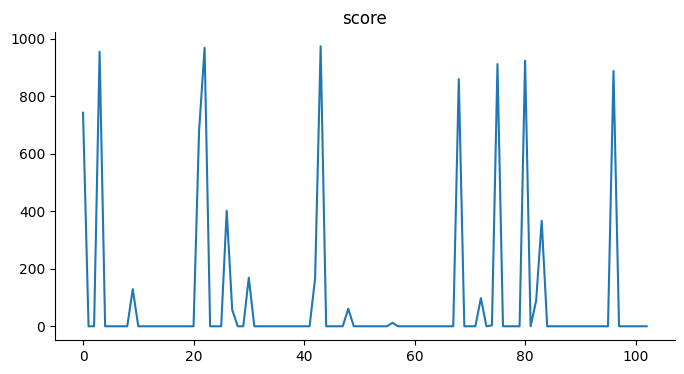

In [17]:
# @title score

from matplotlib import pyplot as plt
df_scores['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

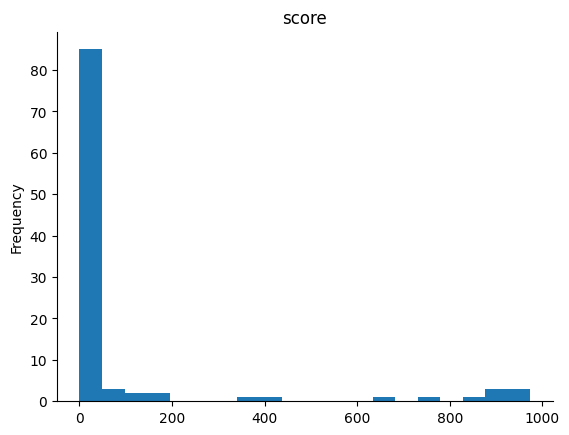

In [16]:
# @title score

from matplotlib import pyplot as plt
df_scores['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
from google.colab import files
files.download("wallet_scores.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>